In [1]:

!pip install scikit-image
!pip install pydot

In [2]:
!pip install Keras-Applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.5 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn


import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

In [4]:

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from sklearn.metrics import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D
import skimage.io
from skimage.transform import rescale, resize
from tensorflow.keras.applications import InceptionResNetV2

import pydot


In [5]:
EPOCHS = 20
BS = 64
DROPOUT_RATE = 0.5

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

Resize_pixelsize = 299

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
! rm -rf train; mkdir train
! unzip -q '/content/drive/MyDrive/CSE499A/Datasets/train.zip' -d train
! unzip -q '/content/drive/MyDrive/CSE499A/Datasets/ck_train.zip' -d train
! unzip -q '/content/drive/MyDrive/CSE499A/Datasets/ck+_train.zip' -d train
! unzip -q '/content/drive/MyDrive/CSE499A/Datasets/train_jaffe.zip' -d train


In [8]:
! rm -rf test; mkdir test
! unzip -q '/content/drive/MyDrive/CSE499A/Datasets/test-public.zip' -d test

In [9]:
! rm -rf dev; mkdir dev
! unzip -q '/content/drive/MyDrive/CSE499A/Datasets/test-public.zip' -d dev

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_datagen(dataset, aug=False):
    if aug =='train':
        datagen = ImageDataGenerator(
                            rescale = 1./255,
                            validation_split =0.2,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True,
                            fill_mode = 'nearest')
    else:
      datagen = ImageDataGenerator(rescale = 1./255)


    return datagen.flow_from_directory(
            dataset,
            target_size=(299, 299),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [11]:
train_generator = get_datagen('/content/train',True)
dev_generator = get_datagen('/content/dev')
test_generator =get_datagen('/content/test')

Found 30533 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [12]:
NUM_CLASSES = 7  #We have 7 classes for classification

# Load the InceptionResNetV2 model
inception_resnet_v2_notop = InceptionResNetV2(include_top=False,
                               weights='imagenet',
                               input_shape=(Resize_pixelsize, Resize_pixelsize, 3),
                               pooling='avg')

# Get the indices of the BatchNorm layers
batch_norm_indices = [i for i, layer in enumerate(inception_resnet_v2_notop.layers) if 'BatchNormalization' in layer.__class__.__name__]

# Freeze the layers up to a certain layer, excluding BatchNorm layers
FROZEN_LAYER_NUM = 249  # Set this to the number of layers you want to freeze

for i in range(FROZEN_LAYER_NUM):
    if i not in batch_norm_indices:
        inception_resnet_v2_notop.layers[i].trainable = False

# Add custom layers on top of the base model
x = inception_resnet_v2_notop.output
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc1')(x)  # You can adjust the number of neurons
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc2')(x)  # You can adjust the number of neurons
x = Dropout(DROPOUT_RATE)(x)
x = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)

# Create the final model
model = Model(inputs=inception_resnet_v2_notop.input, outputs=x)

# Define the learning rate schedule and optimizer
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=ADAM_LEARNING_RATE,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optimizer = Adam(learning_rate=learning_rate_schedule)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.5, patience=10, min_lr=0.00001, verbose=1)
callbacks_list = [rlrop]

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


219055592/219055592 [==============================] - 8s 0us/step


In [13]:
history = model.fit(
    x=train_generator,
    validation_data=dev_generator,
    shuffle=True,
    steps_per_epoch = 28709//BS,
    validation_steps = 3589//BS,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    use_multiprocessing=True
)

Epoch 1/20
448/448 [==============================] - 946s 2s/step - loss: 1.4339 - accuracy: 0.4504 - val_loss: 1.4699 - val_accuracy: 0.4891 - lr: 0.0010
Epoch 2/20
448/448 [==============================] - 869s 2s/step - loss: 1.1073 - accuracy: 0.5883 - val_loss: 1.1532 - val_accuracy: 0.5848 - lr: 0.0010
Epoch 3/20
448/448 [==============================] - 864s 2s/step - loss: 0.9711 - accuracy: 0.6428 - val_loss: 3.6777 - val_accuracy: 0.2494 - lr: 0.0010
Epoch 4/20
448/448 [==============================] - 865s 2s/step - loss: 0.8752 - accuracy: 0.6853 - val_loss: 1.0901 - val_accuracy: 0.6071 - lr: 0.0010
Epoch 5/20
448/448 [==============================] - 863s 2s/step - loss: 0.7341 - accuracy: 0.7360 - val_loss: 1.2085 - val_accuracy: 0.5815 - lr: 0.0010
Epoch 6/20
448/448 [==============================] - 858s 2s/step - loss: 0.5936 - accuracy: 0.7918 - val_loss: 1.2696 - val_accuracy: 0.5781 - lr: 0.0010
Epoch 7/20
448/448 [==============================] - 860s 2s/st

In [14]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(test_generator, 3509 // BS)
print('Test loss, Test acc: ',results_test)


# Evaluate on test data


<ipython-input-14-370b98cc6c28>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  results_test = model.evaluate_generator(test_generator, 3509 // BS)


Test loss, Test acc:  [1.9290579557418823, 0.6174768805503845]


In [15]:
print('\n# Evaluate on dev data')
results_dev = model.evaluate_generator(dev_generator, 3509 // BS)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data


<ipython-input-15-5b76f0701e1a>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  results_dev = model.evaluate_generator(dev_generator, 3509 // BS)


dev loss, dev acc: [1.9060317277908325, 0.6226851940155029]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


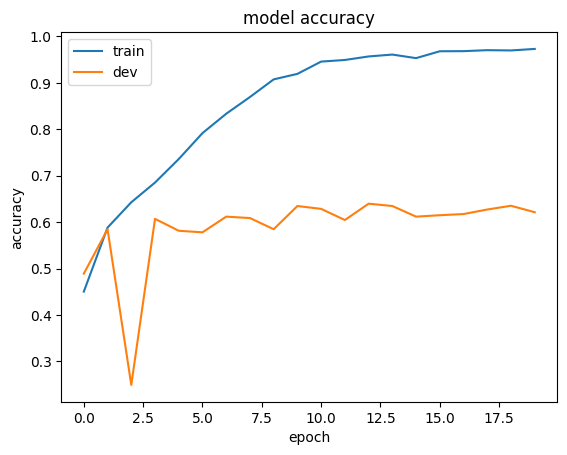

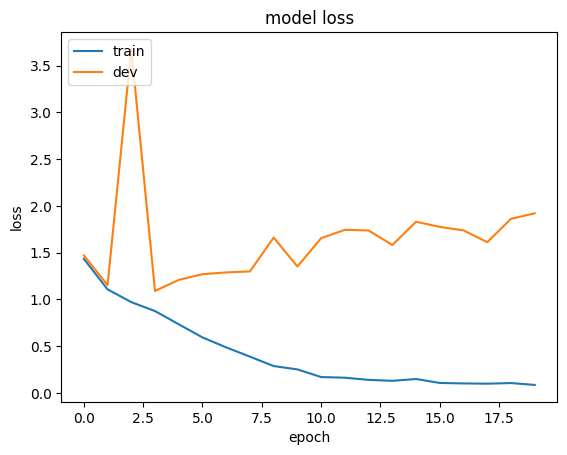

In [16]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [17]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % results_test[1]
model.save('/content/drive/My Drive/CSE499A/models' + 'InceptionResNetV2' + epoch_str + test_acc + '.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
